<a href="https://www.kaggle.com/code/youneseloiarm/mitsui-co-multi-output-with-lags-01?scriptVersionId=258918891" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

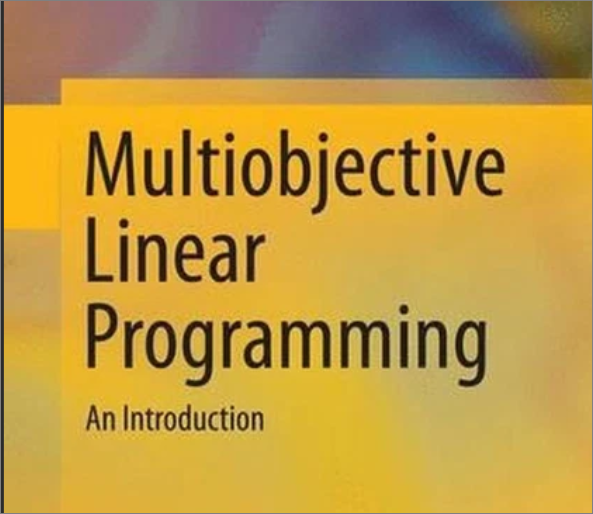


---

**In this notebook, we apply a Linear Model for a multi-target regression problem, predicting 424 outputs simultaneously. We use the standard multi-output approach with efficiency way.**

**This notebook also demonstrates useful techniques, including:**

* How to implement multi-output regression with a Linear Model
* How to handle efficient prediction for a large number of targets
* How to build and optimize a prediction function for API inference



---


In [1]:
import kaggle_evaluation.mitsui_inference_server
from sklearn import *
import numpy as np
import pandas as pd
import polars as pl
import os, warnings
warnings.filterwarnings("ignore")

p = '/kaggle/input/mitsui-commodity-prediction-challenge/'
train = pd.read_csv(p+'train.csv')
trainl = pd.read_csv(p+'train_labels.csv')
traint = pd.read_csv(p+'target_pairs.csv')
#test = pd.read_csv(p+'test.csv')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
trainl = trainl.fillna(0)

In [3]:
target_lag_1 = traint.loc[traint["lag"]==1,"target"].values
target_lag_2 = traint.loc[traint["lag"]==2,"target"].values
target_lag_3 = traint.loc[traint["lag"]==3,"target"].values
target_lag_4 = traint.loc[traint["lag"]==4,"target"].values

In [4]:
Features = [i for i in trainl.columns ]
def creat_lagged_labels(df):
    dt = pd.DataFrame()
    dt["date_id"] = df["date_id"]
    for f in Features[1:]:
        if f in target_lag_1:
            lag = 1
        elif f in target_lag_2:
            lag = 2
        elif f in target_lag_3:
            lag = 3
        elif f in target_lag_4:
            lag = 4    
        dt[f] = df[f].shift(lag).fillna(0)
    return df, dt

In [5]:
_,train_lagged = creat_lagged_labels(trainl)

In [6]:
train_lagged

,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.005948,-0.002851,-0.004675,-0.000639,0.000000,0.000000,-0.006729,0.006066,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.001048,0.023836,-0.008934,-0.022060,0.000000,0.000000,0.037449,0.007658,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.001700,-0.024618,0.011943,0.004778,0.000000,0.000000,-0.012519,-0.016896,0.000000,...,0.000000,0.021239,-0.005595,0.000000,-0.004628,0.033793,0.000000,0.038234,0.000000,0.027310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,1912,-0.001049,0.010689,-0.013043,-0.003886,0.016628,0.002027,0.000903,0.013468,0.006847,...,-0.029812,0.013292,-0.044024,-0.002339,0.023029,0.035976,-0.056517,0.017393,0.006221,0.007932
1913,1913,-0.012596,0.009309,0.007947,0.006477,-0.026216,-0.029487,-0.003287,0.011751,-0.027610,...,0.046582,0.025419,-0.030993,0.038743,0.026417,0.030334,0.029837,0.002042,0.032667,-0.015732
1914,1914,-0.000736,-0.001292,-0.005137,-0.007961,-0.008494,-0.011547,0.004263,0.005670,-0.004822,...,0.028187,0.017681,-0.024106,0.051672,0.005058,0.027760,0.017625,0.004573,0.047833,-0.024001
1915,1915,-0.002294,0.012898,0.009978,0.001567,0.002596,-0.007373,0.007554,0.002661,0.004083,...,0.022579,-0.005401,-0.029530,0.059486,-0.002650,0.014873,0.010885,-0.011085,0.052410,-0.127879


In [7]:
#https://www.kaggle.com/code/metric/mitsui-co-commodity-prediction-metric
def rank_correlation_sharpe_ratio(merged_df: pd.DataFrame) -> float:
    prediction_cols = [col for col in merged_df.columns if col.startswith('prediction_')]
    target_cols = [col for col in merged_df.columns if col.startswith('target_')]
    def _compute_rank_correlation(row):
        non_null_targets = [col for col in target_cols if not pd.isnull(row[col])]
        matching_predictions = [col for col in prediction_cols if col.replace('prediction', 'target') in non_null_targets]
        if not non_null_targets:
            raise ValueError('No non-null target values found')
        if row[non_null_targets].std(ddof=0) == 0 or row[matching_predictions].std(ddof=0) == 0:
            raise ZeroDivisionError('Denominator is zero, unable to compute rank correlation.')
        return np.corrcoef(row[matching_predictions].rank(method='average'), row[non_null_targets].rank(method='average'))[0, 1]
    daily_rank_corrs = merged_df.apply(_compute_rank_correlation, axis=1)
    std_dev = daily_rank_corrs.std(ddof=0)
    if std_dev == 0:
        raise ZeroDivisionError('Denominator is zero, unable to compute Sharpe ratio.')
    sharpe_ratio = daily_rank_corrs.mean() / std_dev
    return float(sharpe_ratio)

def score(solution: pd.DataFrame, submission: pd.DataFrame) -> float:
    assert all(solution.columns == submission.columns)
    submission = submission.rename(columns={col: col.replace('target_', 'prediction_') for col in submission.columns})
    solution = solution.replace(0, None)
    return rank_correlation_sharpe_ratio(pd.concat([solution, submission], axis='columns'))

In [8]:
ycols = ['target_' + str(i) for i in range(424)]
model = linear_model.LinearRegression(n_jobs=-1)
model.fit(train_lagged[Features], trainl[ycols].fillna(0))
preds = model.predict(train_lagged[Features])
preds = pd.DataFrame(preds, columns=ycols)
preds.head()

,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,0.000243,-0.000515,0.000235,0.000396,-0.000476,-0.000786,-0.000108,-0.000918,-0.000057,0.000298,...,-0.000380,0.001097,0.000077,-0.000442,0.000542,-1.317809e-04,0.000287,0.002044,0.000292,-0.002640
1,0.003723,0.003919,-0.002513,-0.003638,0.002948,0.002667,0.003584,0.004048,0.003576,-0.002747,...,0.004748,-0.002261,0.000984,0.006375,-0.011213,-9.045149e-04,-0.005513,0.003402,0.005242,-0.005066
2,0.002894,-0.003690,-0.006184,-0.004599,-0.002075,0.003232,0.001765,-0.000650,0.001598,-0.000595,...,-0.007923,0.006384,-0.000852,-0.005381,-0.003017,9.050327e-07,0.003279,-0.005902,0.003958,0.013748
3,-0.010914,0.003691,-0.007816,-0.000875,-0.000106,0.006342,-0.008814,0.010206,-0.006506,0.003270,...,-0.001547,0.015955,-0.006909,0.006437,-0.007800,1.403031e-03,-0.000880,-0.006806,0.002912,-0.003111
4,-0.002002,-0.003051,0.006345,0.010064,0.007843,-0.005095,-0.006771,-0.004522,0.006026,0.002218,...,-0.005007,0.004353,0.001165,-0.004066,0.000639,1.297339e-02,0.001181,0.020188,0.006615,0.027115


In [9]:
#preds["date_id"] = trainl["date_id"]

In [10]:
#preds = preds[Features]

In [11]:
preds

,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,0.000243,-0.000515,0.000235,0.000396,-0.000476,-0.000786,-0.000108,-0.000918,-0.000057,0.000298,...,-0.000380,0.001097,0.000077,-0.000442,0.000542,-1.317809e-04,0.000287,0.002044,0.000292,-0.002640
1,0.003723,0.003919,-0.002513,-0.003638,0.002948,0.002667,0.003584,0.004048,0.003576,-0.002747,...,0.004748,-0.002261,0.000984,0.006375,-0.011213,-9.045149e-04,-0.005513,0.003402,0.005242,-0.005066
2,0.002894,-0.003690,-0.006184,-0.004599,-0.002075,0.003232,0.001765,-0.000650,0.001598,-0.000595,...,-0.007923,0.006384,-0.000852,-0.005381,-0.003017,9.050327e-07,0.003279,-0.005902,0.003958,0.013748
3,-0.010914,0.003691,-0.007816,-0.000875,-0.000106,0.006342,-0.008814,0.010206,-0.006506,0.003270,...,-0.001547,0.015955,-0.006909,0.006437,-0.007800,1.403031e-03,-0.000880,-0.006806,0.002912,-0.003111
4,-0.002002,-0.003051,0.006345,0.010064,0.007843,-0.005095,-0.006771,-0.004522,0.006026,0.002218,...,-0.005007,0.004353,0.001165,-0.004066,0.000639,1.297339e-02,0.001181,0.020188,0.006615,0.027115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,-0.002417,0.002414,0.009715,0.007350,-0.016508,-0.010643,-0.004814,-0.001458,-0.017440,-0.000292,...,0.010857,-0.004864,0.003971,0.016978,-0.012369,-1.898885e-02,0.011036,-0.016080,0.019207,0.021810
1913,-0.000566,-0.003965,0.000652,-0.001959,-0.001493,0.000601,0.003133,-0.003929,0.002298,0.005063,...,-0.000563,0.001889,0.005535,-0.011252,0.004979,-3.039574e-03,-0.011636,-0.007538,-0.003881,-0.009324
1914,-0.001986,0.005846,-0.004375,-0.000263,0.009450,0.010307,0.001521,0.001691,0.006219,-0.003299,...,-0.003647,-0.006412,-0.001888,-0.020346,-0.009864,-7.098789e-03,-0.004720,-0.007897,-0.015405,-0.018464
1915,0.003317,0.003982,-0.009731,-0.006908,-0.002217,0.006742,0.006068,0.001218,-0.003455,-0.008618,...,0.001228,-0.015249,-0.002522,-0.010504,-0.025084,8.829270e-04,-0.004787,0.002040,-0.011775,-0.015004


In [12]:
score(trainl[ycols][:], preds[:])

1.7046002728944125

In [13]:
#train_lagged[Features]

In [14]:
def predict(
    test: pl.DataFrame,
    lag1: pl.DataFrame, 
    lag2: pl.DataFrame,
    lag3: pl.DataFrame,
    lag4: pl.DataFrame,
) -> pl.DataFrame:
    """
    Predicts target values using lag features.
    Handles empty input and replaces null values with 0.
    """
    # Combine lag features
    X_pred = pl.concat(
        [   test.select(["date_id"]),
            lag1.select(target_lag_1),
            lag2.select(target_lag_2),
            lag3.select(target_lag_3),
            lag4.select(target_lag_4),
        ],
        how="horizontal"
    )
    # If no rows, return all zeros
    if X_pred.height == 0:
        return pd.DataFrame(0, index=range(test.height), columns=Features)

    # Fill nulls with 0
    X_pred = X_pred.fill_null(0)
    X_pred = X_pred.to_pandas()[Features]

    # Predict
    predictions = model.predict(X_pred.tail(1))
    preds_df = pd.DataFrame(predictions, columns=ycols)
    return preds_df


In [15]:
# submission through the API

inference_server = kaggle_evaluation.mitsui_inference_server.MitsuiInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/mitsui-commodity-prediction-challenge/',))

In [16]:
display(pl.read_parquet('/kaggle/working/submission.parquet'))

date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30,target_31,target_32,target_33,target_34,target_35,…,target_387,target_388,target_389,target_390,target_391,target_392,target_393,target_394,target_395,target_396,target_397,target_398,target_399,target_400,target_401,target_402,target_403,target_404,target_405,target_406,target_407,target_408,target_409,target_410,target_411,target_412,target_413,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1827,0.001111,-0.001661,-0.000049,0.000091,-0.00023,0.000382,-0.000338,-0.00135,0.000457,0.000888,-0.000469,0.00027,0.000072,-0.000507,-0.000382,0.00052,0.001339,0.000099,-0.00027,0.000306,-0.000209,-0.000668,0.001362,0.000571,0.001456,-0.001082,0.000742,0.001966,0.001224,0.000029,-0.001956,-0.000964,-0.001674,-0.000025,0.000391,0.000542,…,0.000237,-0.003323,0.002818,-0.003936,-0.005238,-0.0021,0.003299,0.002669,-0.001181,-0.003743,0.005555,-0.000104,-0.000459,0.000135,-0.003377,0.000237,-0.000479,-0.007112,0.000113,-0.001333,-0.000546,0.001076,-0.00071,-0.00046,-0.003101,0.006426,-0.002663,0.002963,0.000048,-0.001993,0.000795,0.000165,-0.000027,-0.000398,0.003028,0.001554,-0.005699
1828,0.001111,-0.001662,-0.000049,0.000091,-0.00023,0.000383,-0.000338,-0.00135,0.000457,0.000889,-0.000469,0.00027,0.000072,-0.000507,-0.000382,0.00052,0.001339,0.0001,-0.00027,0.000306,-0.000208,-0.000668,0.001363,0.000571,0.001457,-0.001083,0.000743,0.001967,0.001224,0.000028,-0.001956,-0.000964,-0.001674,-0.000025,0.000392,0.000543,…,0.000236,-0.003324,0.002819,-0.003939,-0.00524,-0.002101,0.0033,0.002673,-0.001181,-0.003743,0.005559,-0.000104,-0.000457,0.000135,-0.003379,0.000237,-0.000479,-0.00712,0.000114,-0.001334,-0.000547,0.001077,-0.000711,-0.00046,-0.003102,0.006428,-0.002664,0.002965,0.000048,-0.001995,0.000795,0.000164,-0.000027,-0.000399,0.003029,0.001555,-0.0057
1829,0.002257,-0.005491,-0.005025,-0.004674,-0.003433,0.003346,-0.003304,0.004209,-0.001632,0.00567,0.001607,0.000573,0.000198,-0.001423,-0.001715,0.002845,-0.003501,-0.00178,0.001823,0.000222,0.00602,0.000437,0.006084,0.001236,0.006584,-0.000885,0.002179,-0.005673,-0.001619,0.000093,-0.010479,0.003146,-0.002138,0.000733,-0.00306,-0.001679,…,0.00547,0.004272,-0.000479,0.002718,-0.025444,-0.009773,-0.014002,0.003092,0.015826,0.004097,-0.014429,-0.003028,-0.001091,-0.002548,0.004398,0.0033,0.011364,-0.013799,-0.007761,-0.002753,-0.000098,0.009763,0.005127,-0.000895,-0.022172,0.001175,-0.007179,0.007528,-0.000429,0.008534,0.003334,-0.012239,-0.001015,0.001555,0.002755,0.004877,0.001271
1830,0.006146,-0.00816,0.005343,-0.003066,-0.007218,0.003298,0.009377,-0.010644,0.004325,-0.000815,-0.007819,0.003623,-0.009798,0.005006,-0.008293,0.011438,0.010572,0.002884,-0.006799,-0.000568,-0.004671,-0.006142,0.003933,-0.000954,0.0197,-0.018365,-0.003217,0.010998,0.003506,0.013447,0.001313,-0.008364,-0.012636,-0.004548,0.006047,0.004099,…,0.004234,-0.02393,0.01762,0.005421,-0.017501,0.009653,-0.014348,-0.00454,-0.000581,-0.011817,0.003138,-0.001969,0.003507,0.008411,-0.024572,0.014605,-0.001403,-0.023719,0.012748,-0.004289,0.010965,-0.009843,0.003075,0.017863,-0.013504,-0.000029,-0.002217,0.000519,-0.005433,-0.01095,-0.013021,0.017332,0.012384,-0.010166,0.010227,-0.006746,0.015627
1831,-0.007963,0.007466,0.001708,-0.002653,0.003816,0.008774,0.005075,0.007381,-0.002036,-0.002449,-0.002856,-0.000536,0.004945,0.002369,-0.00327,0.00339,-0.008443,0.004